In [1]:
from sklearn.datasets import fetch_openml
import pickle

a = fetch_openml(name="mnist_784")

out = {"data": a["data"].to_numpy(), "labels": list(a["target"].to_numpy())}

with open(f'synth_data_gen/synth_datasets/mnist/set_0.pickle', 'wb') as handle:
    pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/jmad/anaconda3/envs/UMAPorig/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
a.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

# Synthetic data generation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from numpy.random import default_rng

# Function to draw a random rotation in N dimensions
from scipy.stats import special_ortho_group

from itertools import product

import umap

In [5]:
def get_rng(seed_or_rng):
    if isinstance(seed_or_rng, np.random._generator.Generator):
        return seed_or_rng
    else:
        return default_rng(seed=seed_or_rng)

In [6]:
import pickle

# 1. Gaussian clusters with centres in a 2 dimensional plane, rotated in $n$ dimensions

In [6]:
# Datasets

CLUSTER_SIZES = [30, 80, 150, 300]
FINAL_DIM = [4, 8, 16, 32]
NOISE_POINTS = [0, 100, 400]


df = pd.DataFrame(columns=["cluster_size", "final_dim", "noise_points"], data=product(CLUSTER_SIZES, FINAL_DIM, NOISE_POINTS))
df.to_csv("synth_data_gen/synth_datasets/gaussian_clusters_plane/params.csv", index=False)

In [8]:
rng = default_rng(42)


datasets = []

n_clusters = 8
limits = 15
var = 0.5

centres = rng.uniform(low = -limits, high=limits, size=(n_clusters, 2))

rotation_matrices = {j: special_ortho_group(dim=j, seed=rng).rvs(1) for j in FINAL_DIM}

for idx in df.index:
    cluster_size = df.loc[idx, "cluster_size"]
    final_dim = df.loc[idx, "final_dim"]
    noise_points = df.loc[idx, "noise_points"]
    
    cov = var * np.eye(final_dim)
    exp_centres = np.zeros(shape=(n_clusters, final_dim))
    exp_centres[:, :2] = centres.copy()


    clusters = [
        rng.multivariate_normal(mean=exp_centres[j,:], cov=cov, size=cluster_size) for j in range(n_clusters)
    ]
    
    points = np.concatenate(clusters)
    # Rotate points
    points = np.matmul(points, rotation_matrices[final_dim])
    
    # Random uniform noise
    points = np.concatenate([points, rng.uniform(low=np.min(points)-2, high=np.max(points)+2, size=(noise_points, final_dim))])

    labels = [j for j in range(n_clusters) for _ in range(clusters[j].shape[0])]
    labels.extend([-1 for _ in range(noise_points)])
    
    out = {"data": points, "labels": labels}
    
    #with open(f'synth_data_gen/synth_datasets/gaussian_clusters_plane/set_{idx}.pickle', 'wb') as handle:
    #    pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #np.save(f"synth_data_gen/synth_datasets/gaussian_clusters_plane/points_{idx}.npy", points)
    #np.save(f"synth_data_gen/synth_datasets/gaussian_clusters_plane/labels_{idx}.npy", labels)
    break

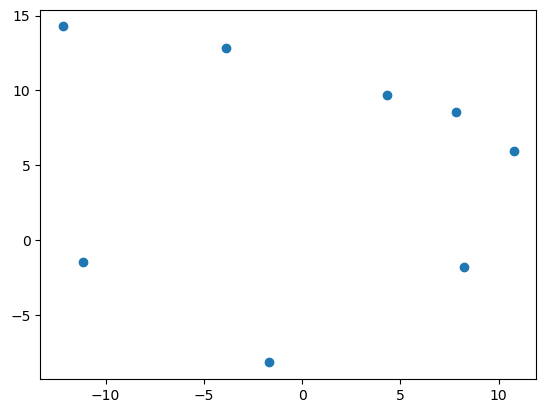

In [12]:
dd = out["data"]

plt.scatter(centres[:,0], centres[:,1])

In [6]:
# for i in df.index:
#     high = np.load(f"synth_data_gen/synth_datasets/type1/points_{i}.npy")
#     labels = np.load(f"synth_data_gen/synth_datasets/type1/labels_{i}.npy")
#     
#     reducer = umap.UMAP(random_state=42)
#     
#     low = reducer.fit_transform(high)
#     
#     np.save(f"synth_data_gen/trials_type1/emb_{i}.npy", low)

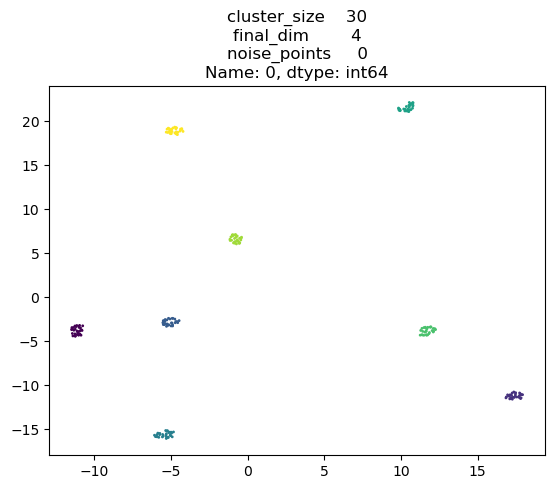

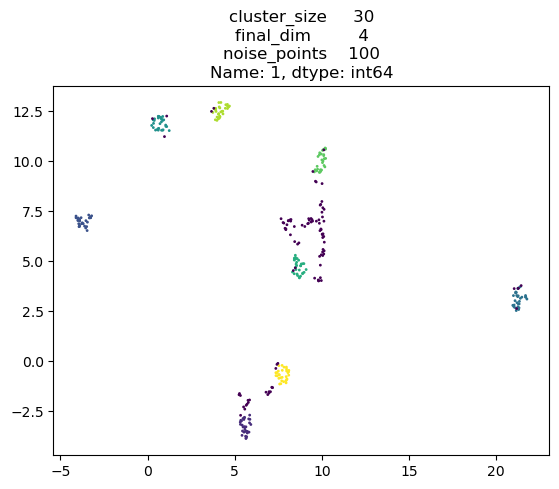

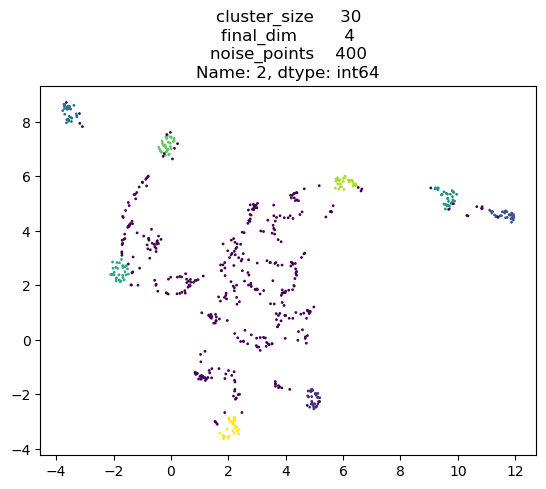

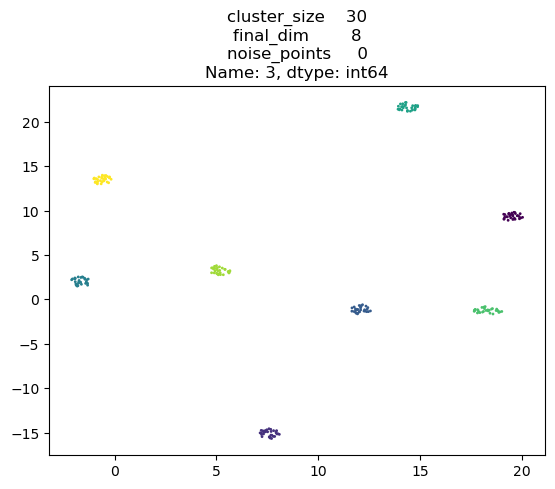

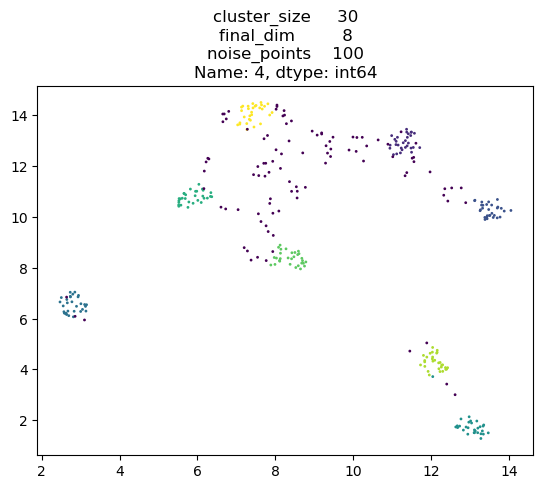

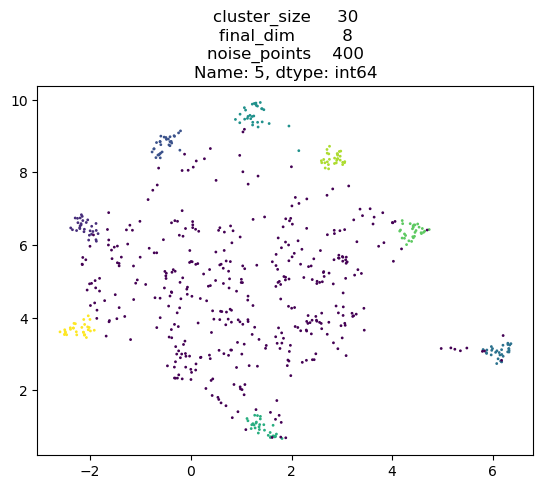

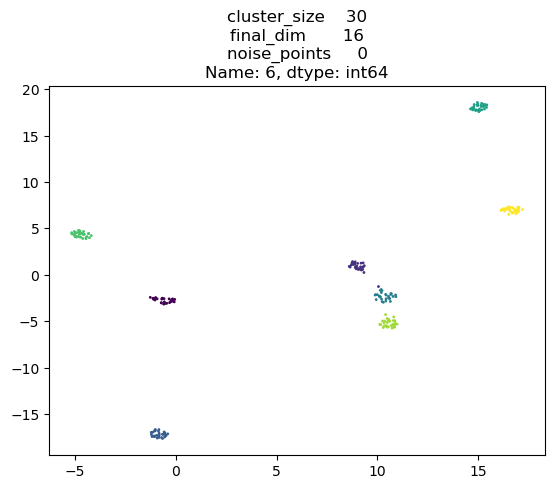

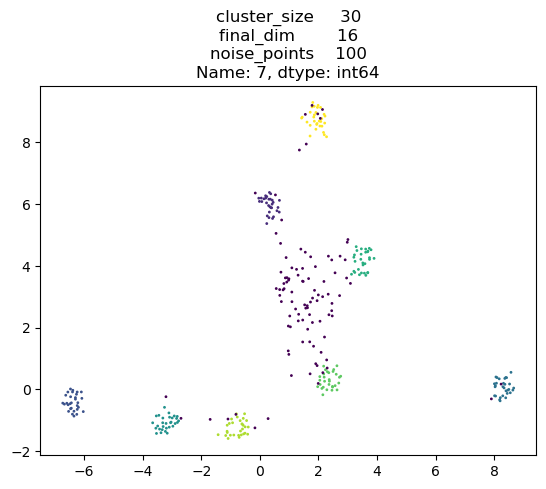

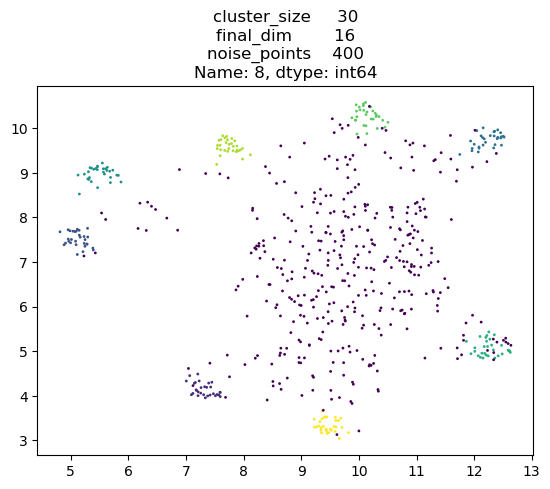

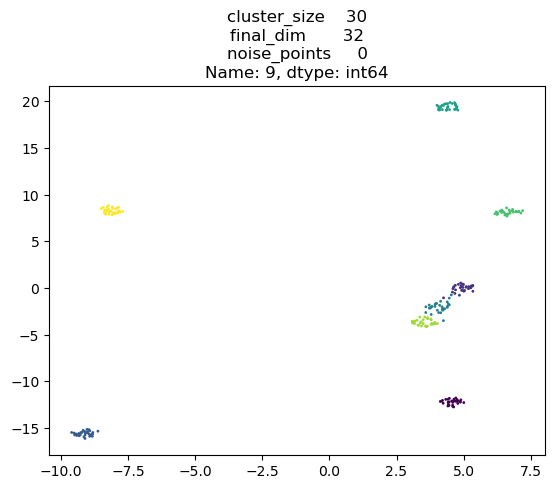

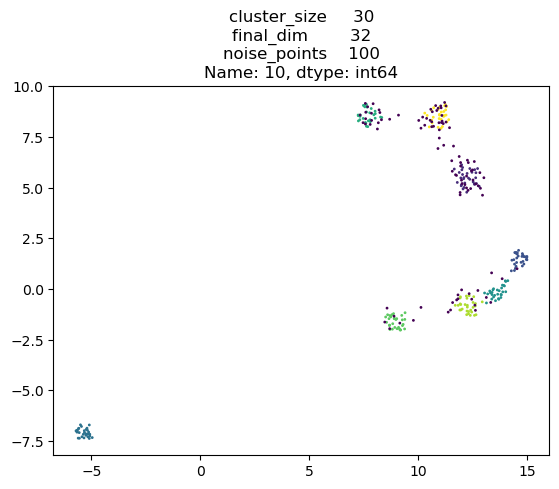

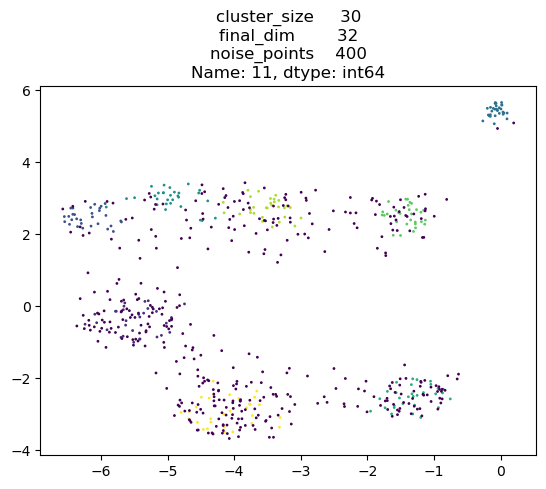

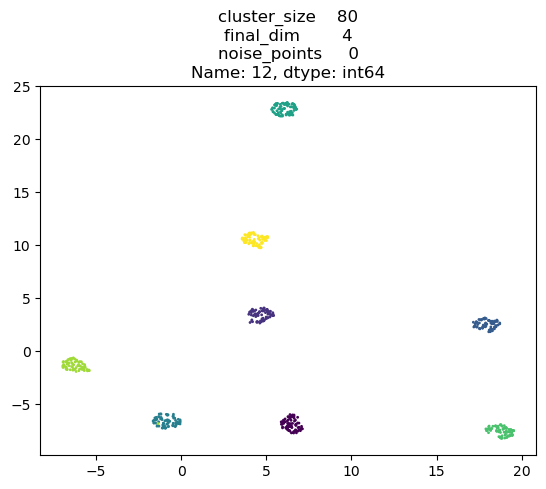

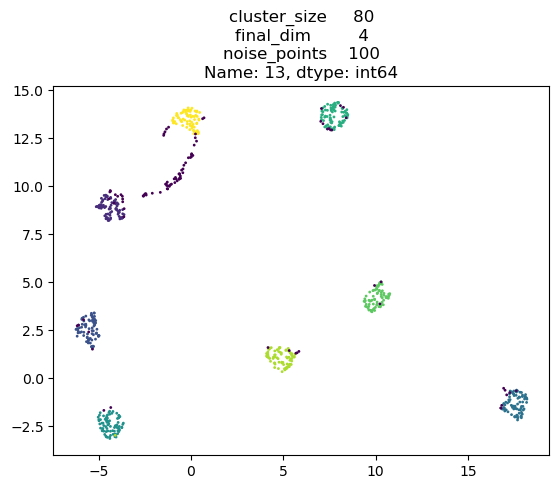

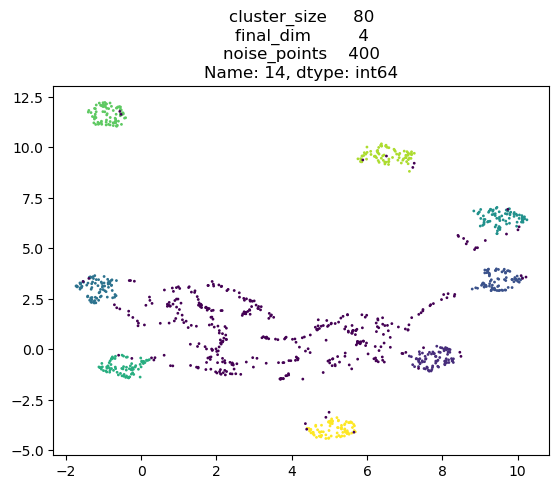

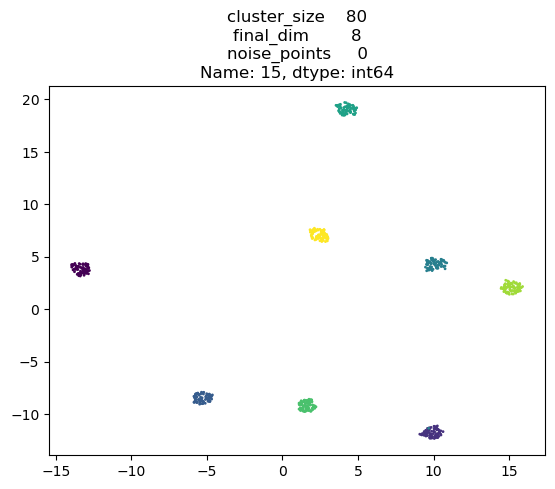

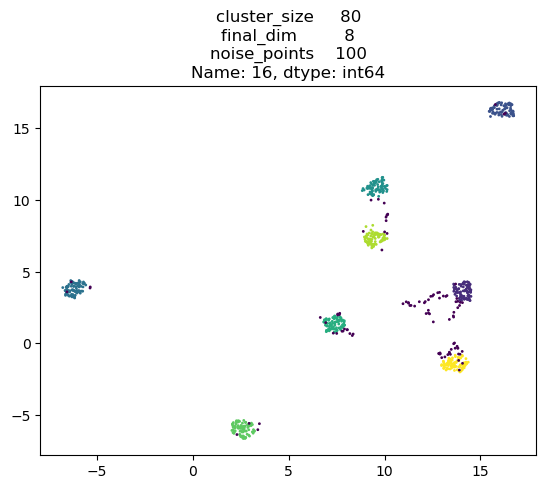

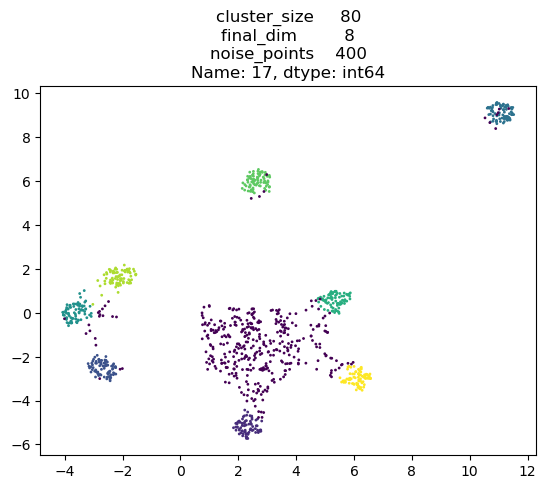

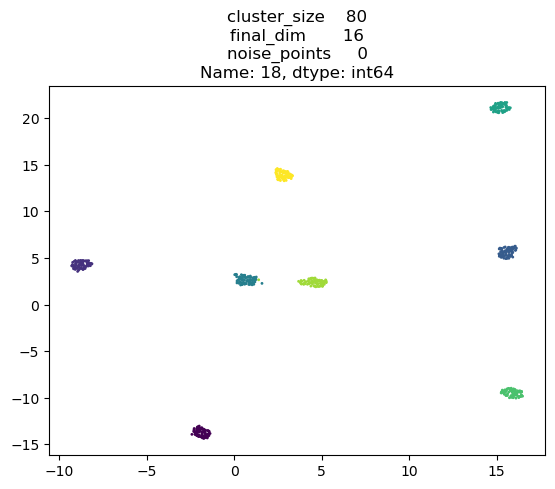

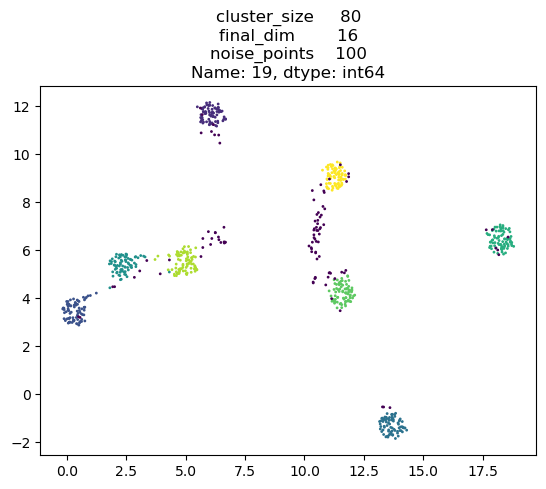

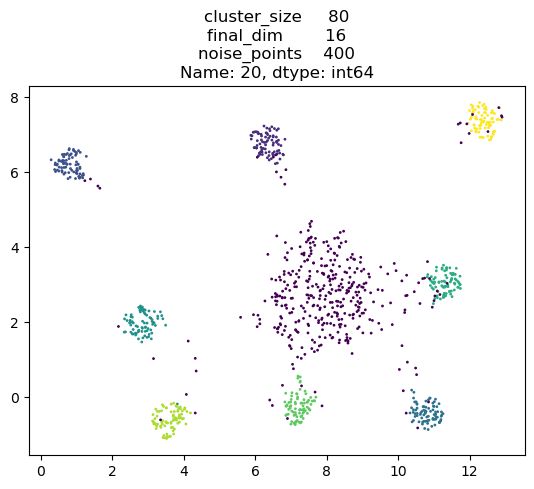

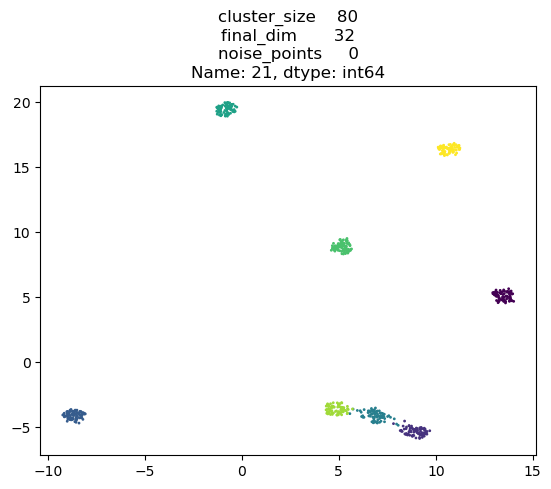

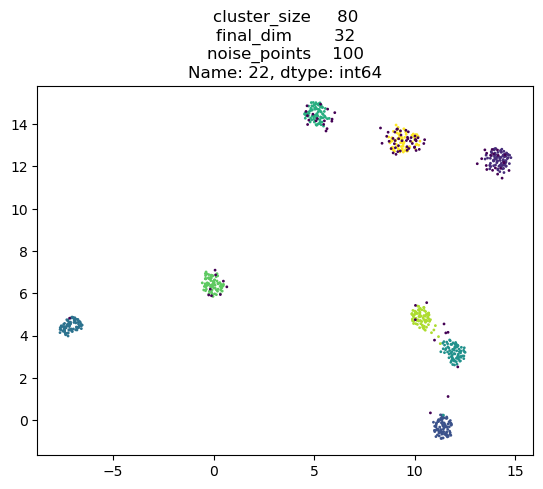

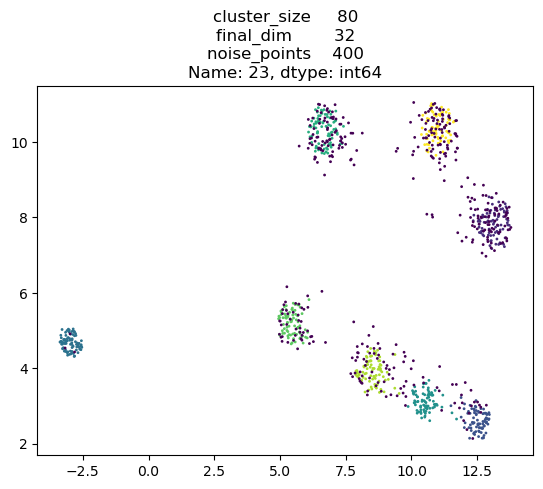

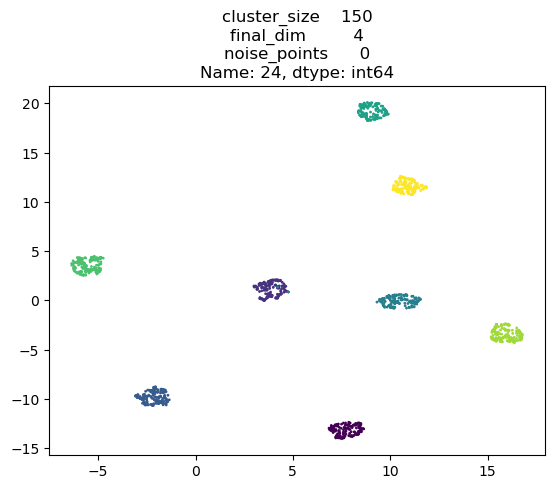

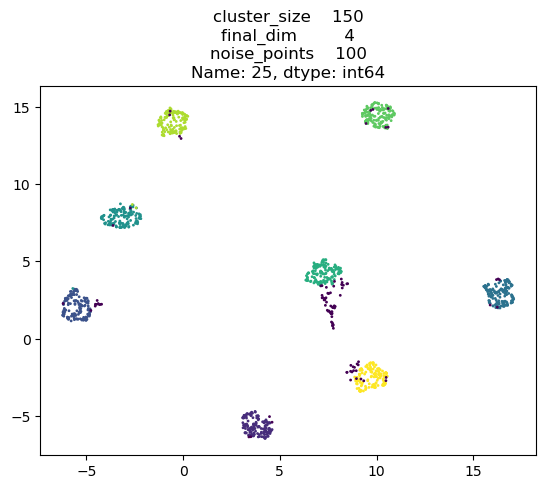

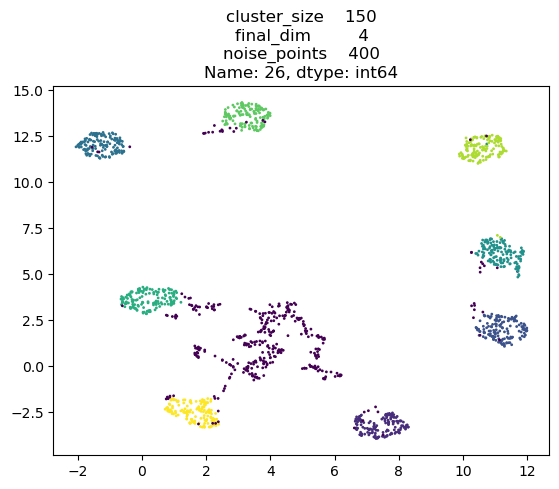

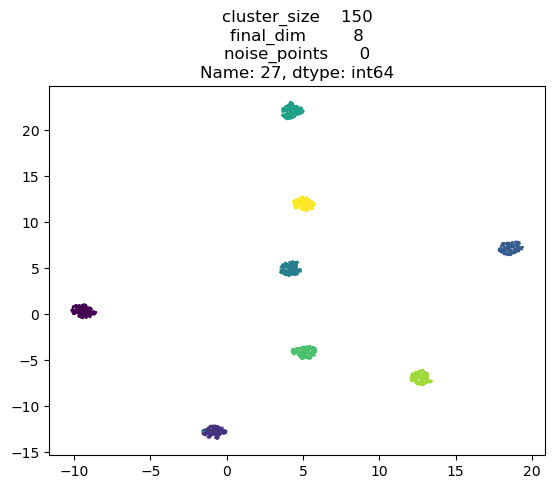

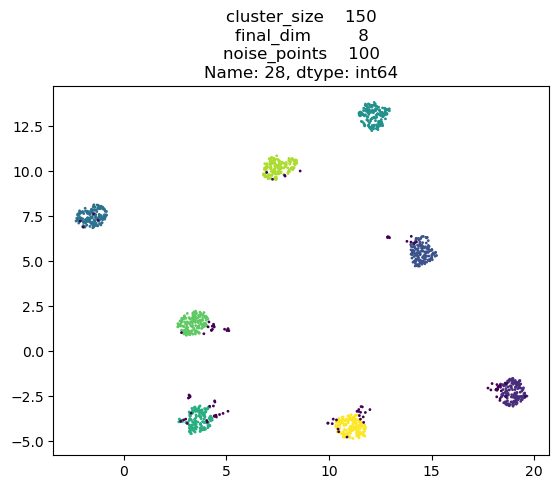

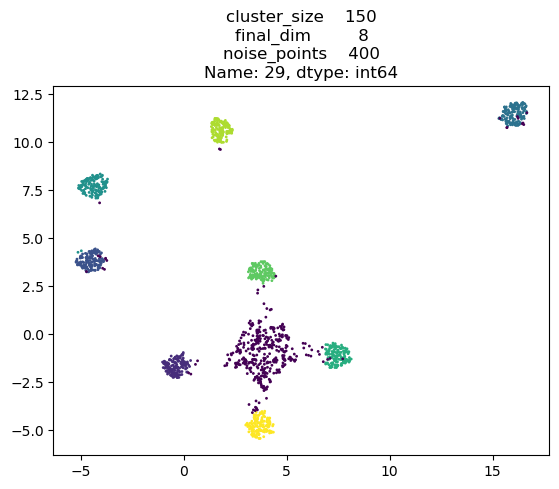

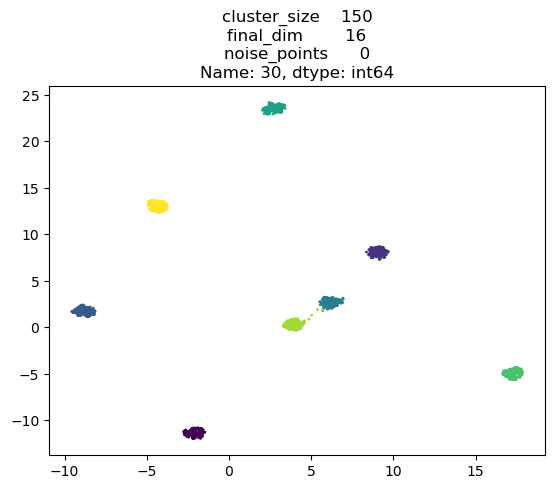

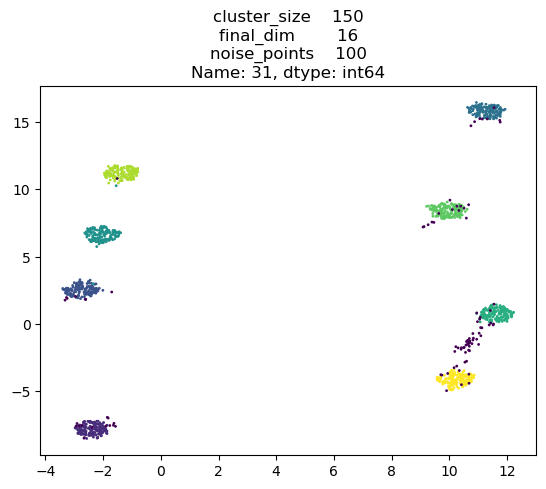

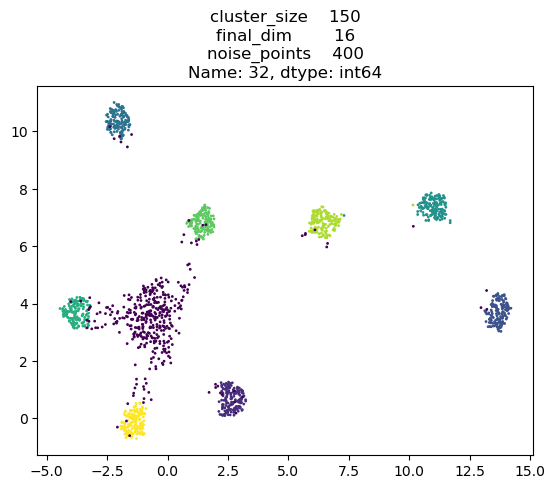

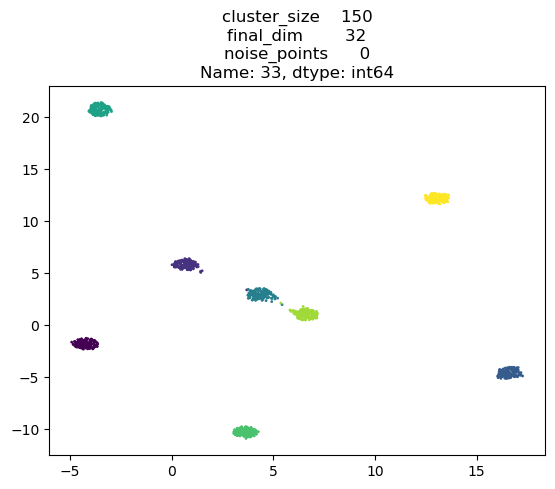

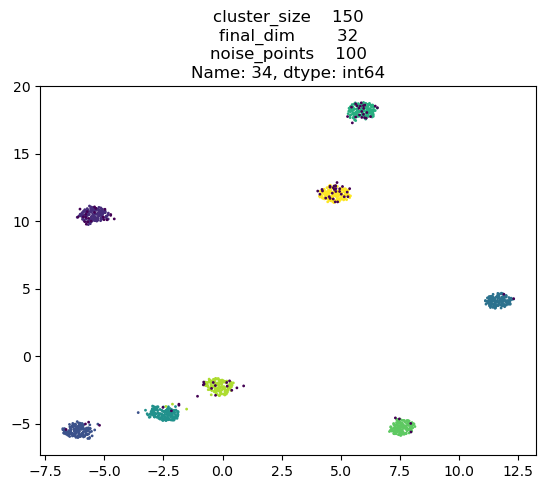

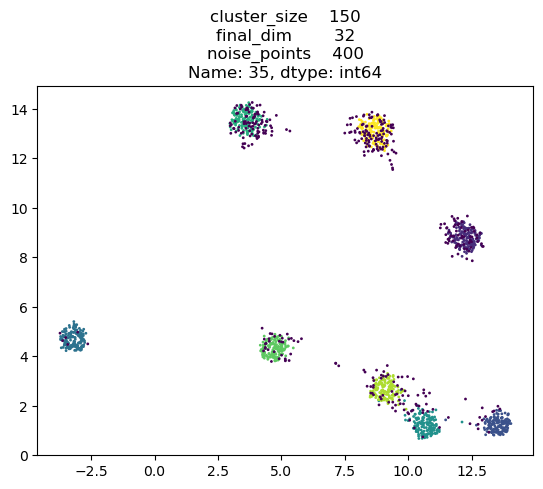

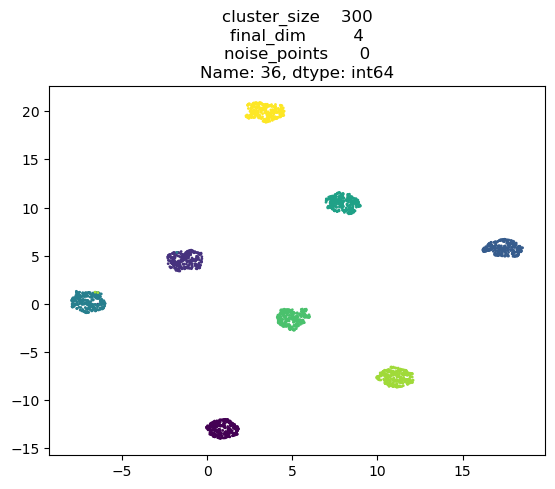

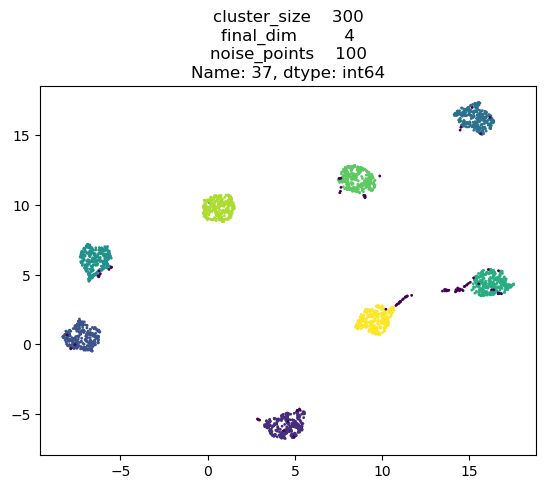

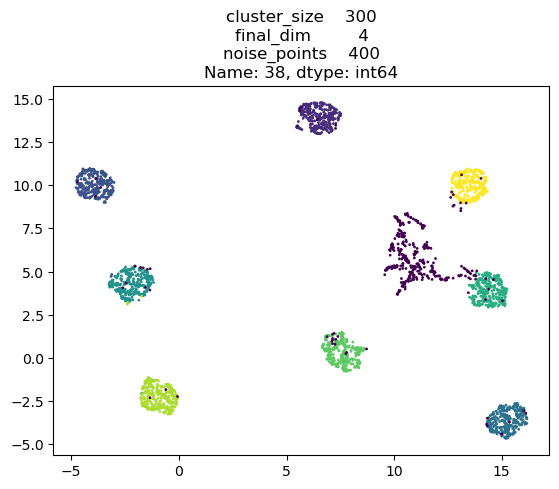

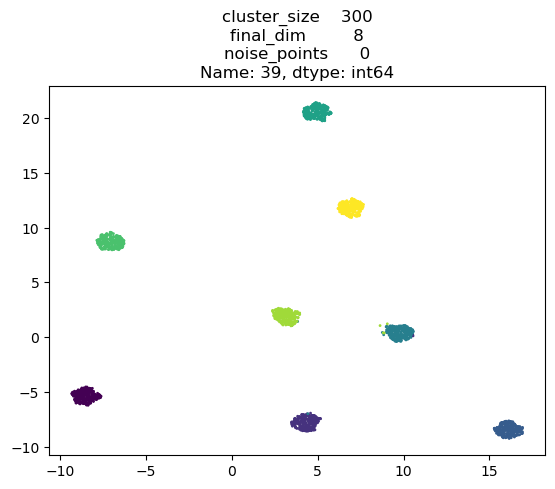

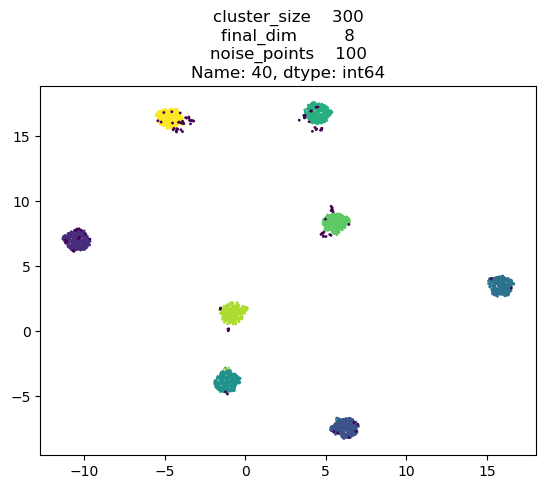

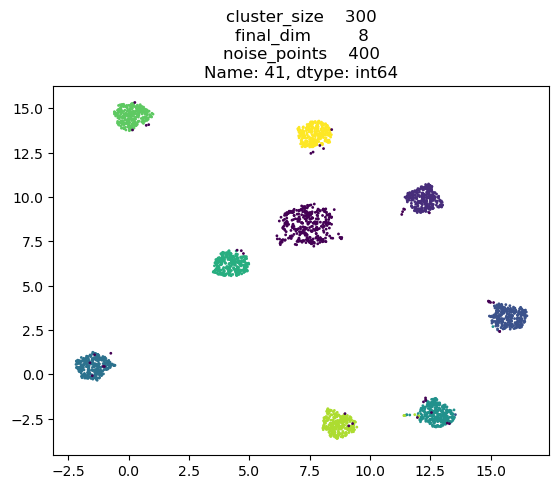

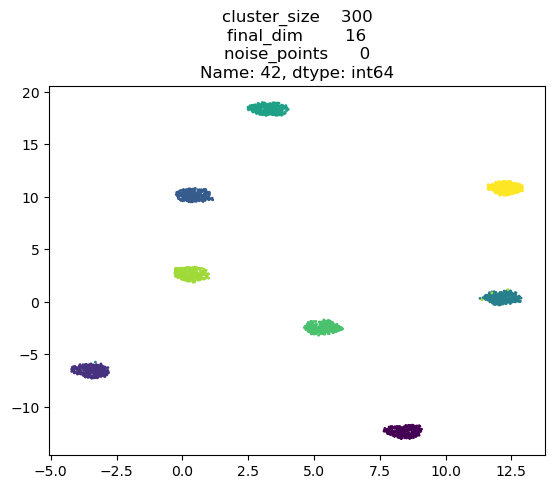

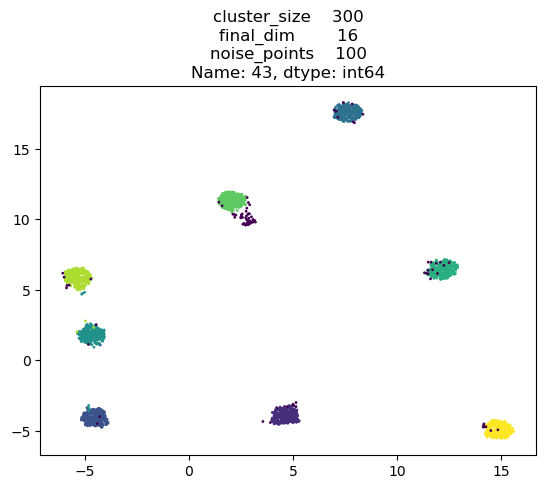

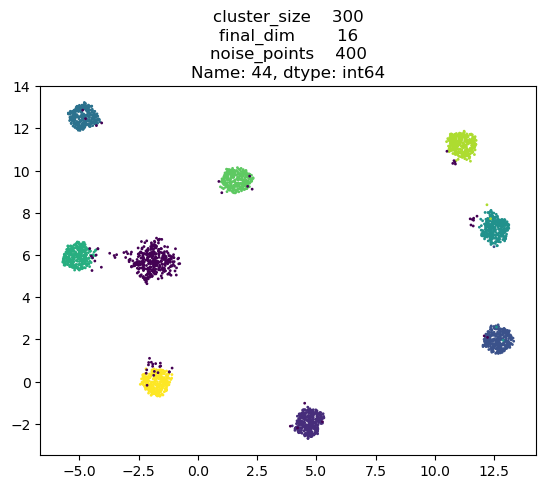

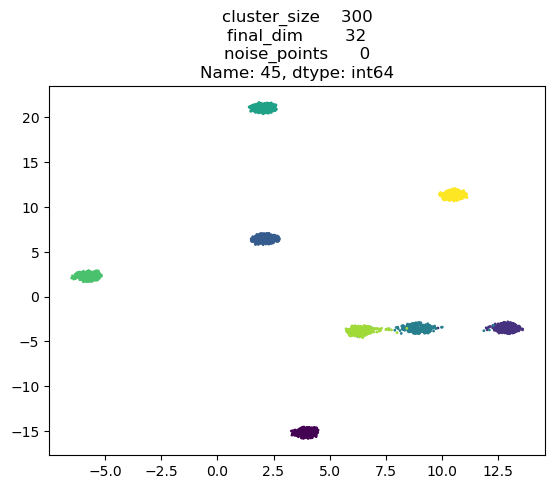

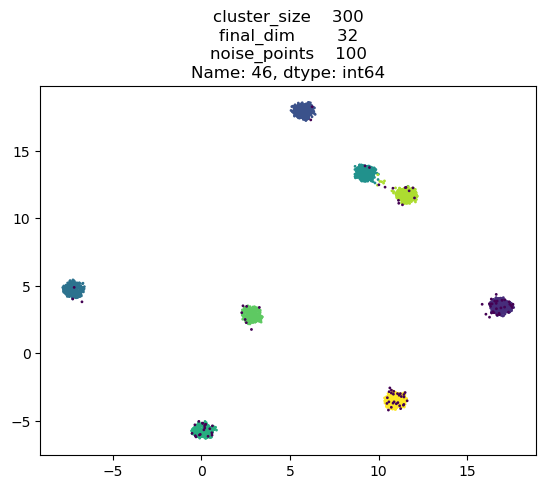

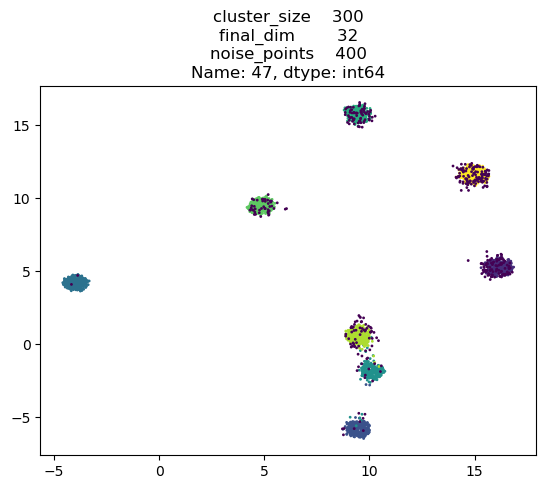

In [7]:
# for i in df.index:
#     emb = np.load(f"synth_data_gen/trials_type1/emb_{i}.npy")
#     labels = np.load(f"synth_data_gen/synth_datasets/type1/labels_{i}.npy")
#     
#     plt.scatter(emb[:,0], emb[:,1], c=labels, s=1)
#     plt.title(str(df.loc[i,:]))
#     plt.show()
#     plt.close()

# 2.


In [17]:
def gen_multivariate_normal_clusters(mean, covs, sample_sizes, seed=42, angles=None):
    """
    Returns points generated from `dims`-dimensional multivariate normal distributions centred on
    each point in `means`, covariance matrices in `covs` and with `sample_sizes` points sampled from each
    distribution

    Args:
        means (list): 1D numpy array
        covs (list): list of `dims` x `dims` 2D numpy arrays, positive definite and symmetric.
        sample_sizes (list): list of ints
        seed: random state seed, or np.random._generator.Generator
        angles (list): list of angles with which to rotate each cluster
    Returns:
        points: numpy array with generated points
    """

    rng = get_rng(seed)
    if angles is None:
        angles = [0] * len(sample_sizes)
    
    points = np.concatenate([np.matmul(
            rng.multivariate_normal(mean=np.array([0]*mean.shape[0]),
                                    cov=covs[i],
                                    size=sample_sizes[i]),
        np.array([[np.cos(angles[i]), -np.sin(angles[i])],[np.sin(angles[i]), np.cos(angles[i])]])
        ) + mean for i in range(len(sample_sizes))
    ])

    return points

def get_isotropic_gaussian_clusters(seed, num_clusters, max_sample_size, std, plot=True, cmap="viridis", labels=None):
    rng = default_rng(seed=seed)
    centres = rng.uniform(low = -5, high = 5, size=(num_clusters, 2))
    cov = np.array([[std,0],[0,std]])
    points = np.concatenate([
        gen_multivariate_normal_clusters(centres[i,:], covs=[cov],
                                        sample_sizes=[max_sample_size],
                                        seed=rng) for i in range(num_clusters)
    ])
    if labels is None:
        classes =[i for i in range(num_clusters) for _ in range(max_sample_size) ]
    else:
        classes =[labels[i] for i in range(num_clusters) for _ in range(max_sample_size) ]

    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(points[:, 0], points[:, 1], s=2, c=classes, cmap=cmap)
        plt.xlim((-6,6))
        plt.ylim((-6,6))

    return points, classes  

In [18]:
means = [
    np.array([0,0]),
    np.array([-6, -6]),
    np.array([2,8]),
    np.array([2,8])
]

covs = [
    np.array([[10,0],[0,0.5]]),
    np.array([[10,0],[0,0.5]])
]

sample_sizes = [300, 300]

angles = [-np.pi/6, np.pi/6]

In [19]:
seed=3

rng = get_rng(seed)


points_0 = gen_multivariate_normal_clusters(mean=np.array([12,12]),
                                                  covs=covs,
                                                  sample_sizes=sample_sizes, seed=rng, angles=angles)
classes_0 = [0 for _ in range(points_0.shape[0])]

num_clusters = 2
max_sample_size = 100
std = 1
points_1, classes_1 = get_isotropic_gaussian_clusters(rng, num_clusters, max_sample_size, std, plot=False, labels=[1,2])

num_clusters = 1
max_sample_size = 100
std = 0.5
points_2, classes_2 = get_isotropic_gaussian_clusters(rng, num_clusters, max_sample_size, std, plot=False, labels=[3])
points_2[:, 0] -= 5
points_2[:, 1] -= 5

sample_size=300
a=15
sample_3 = rng.random(sample_size) * (3/2) * np.pi + 0.5 * np.pi
points_3 = np.zeros((sample_size, 2))
points_3[:, 0] = a * np.cos(sample_3)
points_3[:, 1] = a * np.sin(sample_3)
points_3 += rng.normal(scale=0.3, size=points_3.shape)

classes = np.concatenate([classes_0, classes_1, classes_2, [4 for _ in range(points_3.shape[0])]])
points = np.concatenate([points_0, points_1, points_2, points_3])



FINAL_DIMS = [4, 8, 16, 32]
df = pd.DataFrame(data=FINAL_DIMS, columns=["dims"])
df.to_csv("synth_data_gen/synth_datasets/shapes/params.csv")
df.to_csv("synth_data_gen/synth_datasets/shapes_noise/params.csv")

noise=100
for j in range(len(FINAL_DIMS)):

    newpoints = np.zeros((points.shape[0], FINAL_DIMS[j]))
    newpoints[:, :2] = points.copy()
    
    newpoints = np.matmul(newpoints, special_ortho_group(dim=FINAL_DIMS[j], seed=rng).rvs(1))
    
    data = {"data": newpoints, "labels": classes}
    
    #np.save(f"synth_data_gen/synth_datasets/shapes/points_{j}_dims.npy", newpoints)
    #np.save(f"synth_data_gen/synth_datasets/shapes/labels_{j}_dims.npy", classes)
        
    with open(f'synth_data_gen/synth_datasets/shapes/set_{j}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    newpoints = np.concatenate([newpoints,
                               rng.uniform(low=newpoints.min()-2, high=newpoints.max()+2,
                                          size=(noise, FINAL_DIMS[j]))])
    classes_noise = np.concatenate([classes, [-1 for _ in range(noise)]])
    
    data = {"data": newpoints, "labels": classes_noise}

        
    with open(f'synth_data_gen/synth_datasets/shapes_noise/set_{j}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    #np.save(f"synth_data_gen/synth_datasets/type2/points_{j}_dims_noise.npy", newpoints)
    #np.save(f"synth_data_gen/synth_datasets/type2/labels_{j}_dims_noise.npy", classes_noise)

In [20]:
newpoints.shape

(1300, 32)

(-20.0, 20.0)

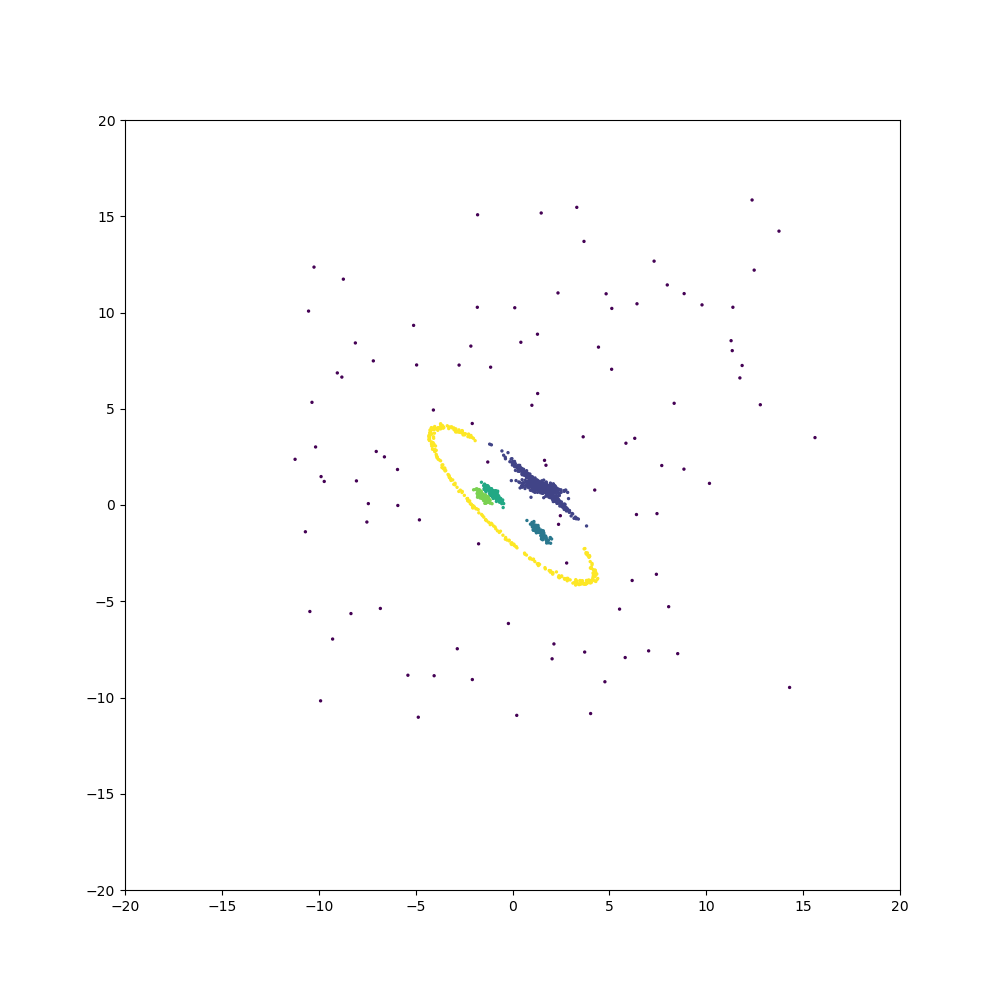

In [21]:
fig, axs = plt.subplots(figsize=(10,10))
axs.scatter(newpoints[:,2], newpoints[:,20], c=classes_noise, s=2)
axs.set_xlim((-20,20))
axs.set_ylim((-20,20))

In [19]:
emb = umap.UMAP().fit_transform(newpoints)

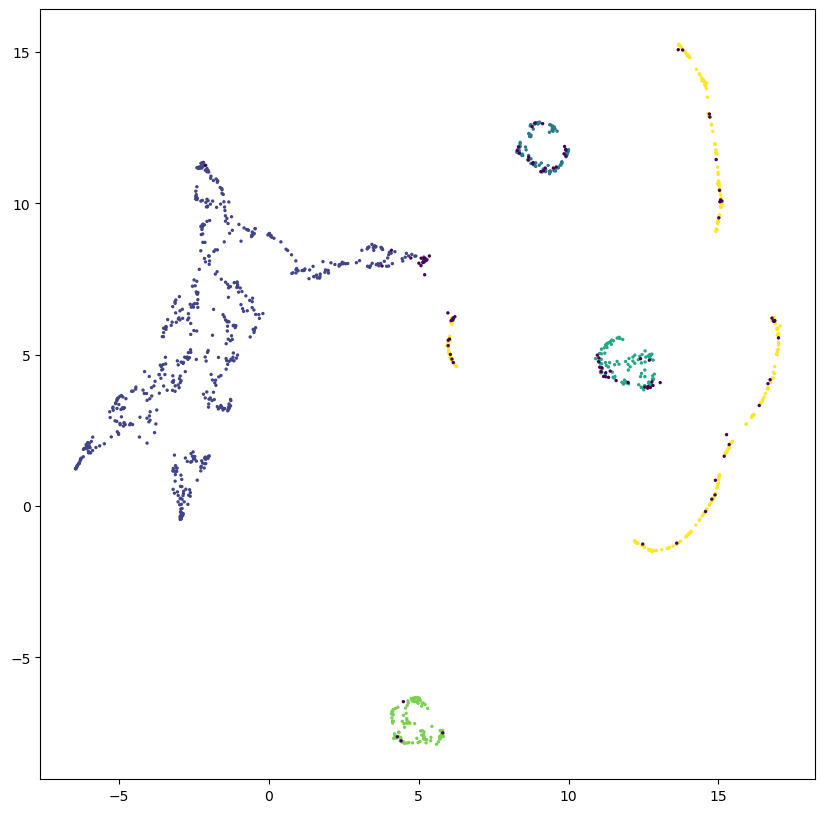

In [20]:
fig, axs = plt.subplots(figsize=(10,10))
axs.scatter(emb[:,0], emb[:,1], c=classes_noise, s=2)
plt.show()

# 3. Hilbert curves

In [7]:
from hilbertcurve.hilbertcurve import HilbertCurve

def get_hilbert_curve(dim, approx, inbetween, final_dims, std=0.1, rng=42):
    rng = default_rng(rng)
    
    hc = HilbertCurve(approx, dim, n_procs=-1)
    points = np.array(hc.points_from_distances(list(range(2 ** (approx*dim)))))

    newp = np.concatenate([
        np.concatenate([
            np.linspace(points[i,j], points[i+1,j], inbetween)[:-1].reshape((-1,1)) for j in range(dim)

        ], axis=1) for i in range(points.shape[0]-1)]
    )
    newp = np.concatenate([newp, points[-1,:].reshape((1,-1))])
    
    points = np.zeros((newp.shape[0], final_dims))
    points[:, :dim] = newp.copy()
    
    points += rng.multivariate_normal(mean=final_dims*[0], 
                                      cov=std*np.eye(final_dims), size=points.shape[0]) 

    
    
    points = np.matmul(points, special_ortho_group(dim=final_dims, seed=rng).rvs(1))

    
    return points

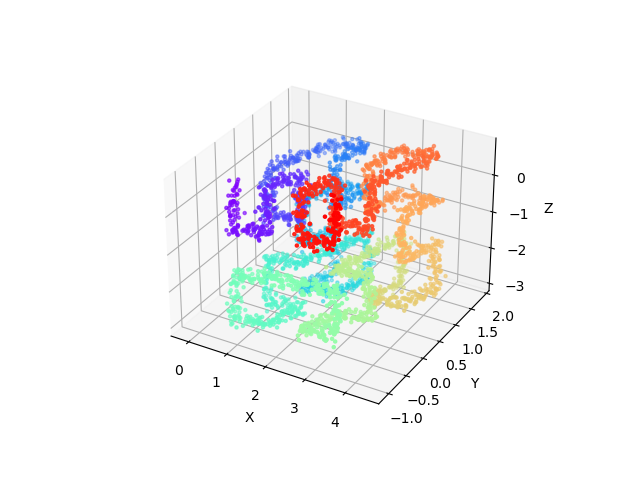

In [12]:
a = get_hilbert_curve(dim=3, approx=2, inbetween=50, final_dims=4, std=0.005)
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a[:,0], a[:,1], a[:,3], s=5, c=range(a.shape[0]), cmap="rainbow")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [73]:
a.shape

(3088, 10)

In [74]:
emb = umap.UMAP(n_components=2).fit_transform(a)

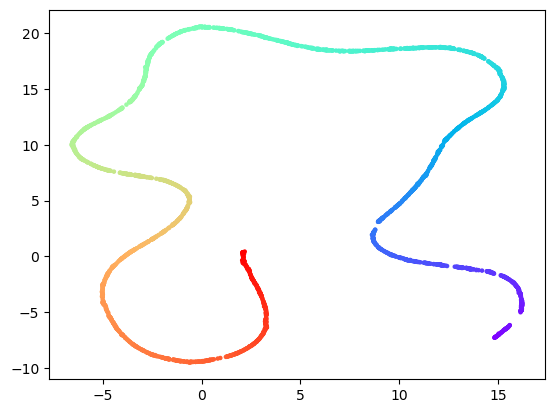

In [76]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(emb[:,0], emb[:,1], s=5, c=range(a.shape[0]), cmap="rainbow")
plt.show()

In [14]:
DIMS = [3, 5]
APPROX = [2]
INBETWEEN = [5, 15, 30]
FINAL_DIMS = [4, 8, 16, 32]

In [15]:
_ = get_hilbert_curve(dim=5, approx=2, inbetween=30, final_dims=16)

In [16]:
raw_params = product(DIMS, APPROX, INBETWEEN, FINAL_DIMS)
params=[]
for x in raw_params:
    if x[0] <= x[3]:
        params.append(x)
df = pd.DataFrame(data=params, columns=["n", "p", "inbetween", "final_dim"])
df.to_csv('synth_data_gen/synth_datasets/hilbert/params.csv', index=False)


for idx in df.index:
    dim=df.loc[idx, "n"]
    approx = df.loc[idx, "p"]
    inbetween = df.loc[idx, "inbetween"]
    final_dim = df.loc[idx, "final_dim"]
    
    points = get_hilbert_curve(dim=dim, approx=approx, inbetween=inbetween, final_dims=final_dim, std=0.005)
    out = {"data": points}
    
    with open(f'synth_data_gen/synth_datasets/hilbert/set_{idx}.pickle', 'wb') as handle:
        pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [390]:
a = get_hilbert_curve(dim=3, approx=3, inbetween=60)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=3_p=3_bw=60.npy", a)
b = get_hilbert_curve(dim=3, approx=3, inbetween=45)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=3_p=3_bw=45.npy", b)

c = get_hilbert_curve(dim=3, approx=3, inbetween=30)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=3_p=3_bw=30.npy", c)

d = get_hilbert_curve(dim=3, approx=3, inbetween=15)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=3_p=3_bw=15.npy", d)

e = get_hilbert_curve(dim=3, approx=3, inbetween=5)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=3_p=3_bw=5.npy", e)


f = get_hilbert_curve(dim=3, approx=4, inbetween=15)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=3_p=4_bw=15.npy", f)

g = get_hilbert_curve(dim=3, approx=4, inbetween=5)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=3_p=4_bw=5.npy", g)

h = get_hilbert_curve(dim=4, approx=3, inbetween=15)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=4_p=3_bw=15.npy", h)

j = get_hilbert_curve(dim=4, approx=3, inbetween=5)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=4_p=3_bw=5.npy", j)

k = get_hilbert_curve(dim=4, approx=2, inbetween=60)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=4_p=2_bw=60.npy", k)

l = get_hilbert_curve(dim=4, approx=2, inbetween=30)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=4_p=2_bw=30.npy", l)

m = get_hilbert_curve(dim=4, approx=2, inbetween=15)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=4_p=2_bw=15.npy", m)

n = get_hilbert_curve(dim=5, approx=2, inbetween=30)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=5_p=2_bw=30.npy", n)

o = get_hilbert_curve(dim=6, approx=2, inbetween=10)
np.save("synth_data_gen/synth_datasets/type3/hilbert_n=6_p=2_bw=10.npy", o)


(30150, 3)
(22485, 3)
(14820, 3)
(7155, 3)
(2045, 3)
(57331, 3)
(16381, 3)
(57331, 4)
(16381, 4)
(15046, 4)
(7396, 4)
(3571, 4)
(29668, 5)
(36856, 6)


# 4

In [43]:
t = np.linspace(0, 500000, 5000)

In [51]:
DIMS = [5, 15, 25]
COV = [1, 3, 10]

df = pd.DataFrame(columns=["dims", "cov"], data=product(DIMS, COV))
df.to_csv("synth_data_gen/synth_datasets/type4/params.csv", index=False)

In [52]:
[(j+1)//2  for j in range(1,dims)]

[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12]

In [80]:
for i in df.index:
    dims = df.loc[i, "dims"]
    cov = df.loc[i, "cov"]


    p = np.concatenate([(j+1)//2 * np.sin(((j+2)//2)*t + ((j+1)%2)*np.pi/2).reshape(-1,1) for j in range(1,dims+1)],axis=1)

    rng = default_rng(33)
    noise = rng.multivariate_normal(mean=dims*[0], cov=cov*np.eye(dims), size=p.shape[0])

    newp = p+noise
    
    np.save(f"synth_data_gen/synth_datasets/type4/points_{i}.npy", newp)

In [81]:
newp.shape

(5000, 25)

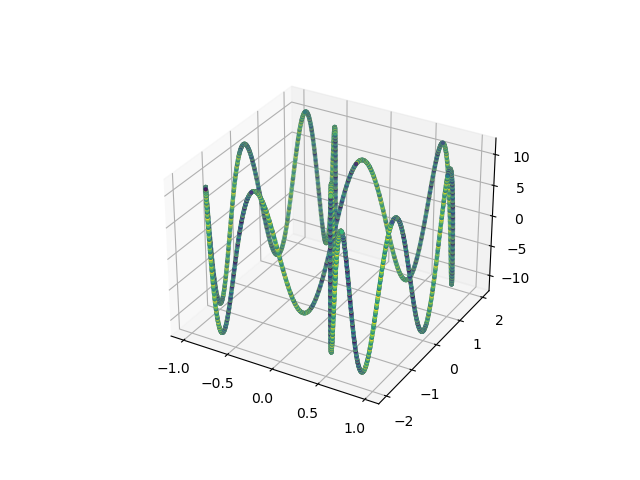

In [82]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[:,0], p[:,2], p[:,20], s=5, c=range(p.shape[0]))

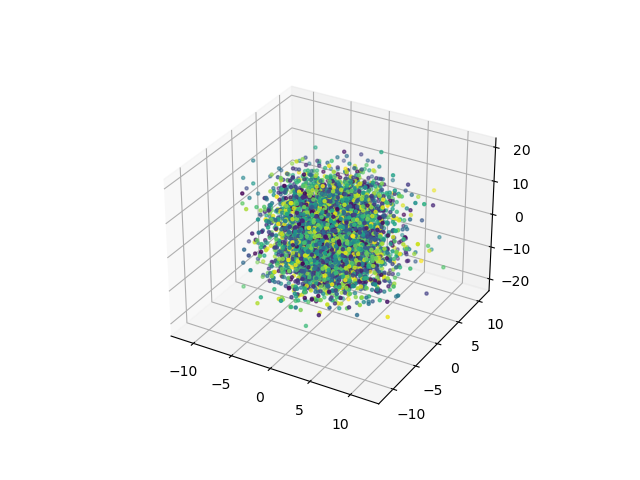

In [83]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newp[:,0], newp[:,1], newp[:,18], s=5, c=range(p.shape[0]))

In [93]:
reducer = umap.UMAP(random_state=42, n_neighbors=100)

aa = np.load(f"synth_data_gen/synth_datasets/type4/points_{0}.npy")
emb = reducer.fit_transform(aa)

In [85]:
%matplotlib inline

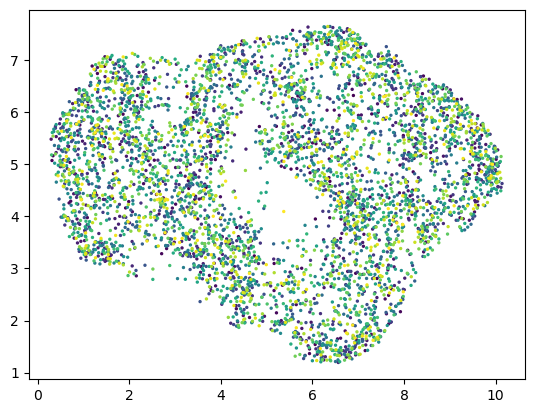

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(emb[:,0], emb[:,1], c=t, s=2)

-------------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng

# Function to draw a random rotation in N dimensions
from scipy.stats import special_ortho_group

from itertools import product

import umap

In [4]:
df = pd.read_csv("synth_data_gen/synth_datasets/type1/params.csv")

In [23]:
try_11 = pd.DataFrame(columns=["n_neighbors", "time"])
try_11.n_neighbors = [10, 40, 70, 100, 200, 400]

for ii in range(df.shape[0]):
    print(ii)
    high = np.load(f"synth_data_gen/synth_datasets/type1/points_{ii}.npy")
    labels = np.load(f"synth_data_gen/synth_datasets/type1/labels_{ii}.npy")

    for idx in range(try_11.shape[0]):
        params = try_11.iloc[idx, :-1].to_dict()
        print(params)
        
        reducer = umap.UMAP(random_state=42, **params)
        
        embedding = reducer.fit_transform(high)
        
        np.save(f"synth_data_gen/try_11/embedding_{ii}_params_{idx}.npy", embedding)
        
        


0
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}


/home/jmad/Documents/MASTER/TFM/REPO/umap/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


1
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}


/home/jmad/Documents/MASTER/TFM/REPO/umap/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


2
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
3
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}


/home/jmad/Documents/MASTER/TFM/REPO/umap/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


4
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}


/home/jmad/Documents/MASTER/TFM/REPO/umap/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


5
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
6
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}


/home/jmad/Documents/MASTER/TFM/REPO/umap/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


7
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}


/home/jmad/Documents/MASTER/TFM/REPO/umap/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


8
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
9
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}


/home/jmad/Documents/MASTER/TFM/REPO/umap/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


10
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}


/home/jmad/Documents/MASTER/TFM/REPO/umap/umap/umap_.py:2434: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


11
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
12
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
13
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
14
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
15
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
16
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
17
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
18
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors

In [36]:
df = pd.read_csv("synth_data_gen/synth_datasets/type2/params.csv")

try_21 = pd.DataFrame(columns=["n_neighbors", "time"])
try_21.n_neighbors = [10, 40, 70, 100, 200, 400]

for j in df.dims:
    high = np.load(f"synth_data_gen/synth_datasets/type2/points_{j}_dims.npy")    
    high_noise = np.load(f"synth_data_gen/synth_datasets/type2/points_{j}_dims_noise.npy")

    for idx in range(try_21.shape[0]):
        params = try_21.iloc[idx, :-1].to_dict()
        print(params)
        
        reducer = umap.UMAP(random_state=42, **params)
        
        embedding = reducer.fit_transform(high)
        
        np.save(f"synth_data_gen/try_21/embedding_{j}_dims_params_{idx}.npy", embedding)
        
                
        reducer = umap.UMAP(random_state=42, **params)
        
        embedding = reducer.fit_transform(high_noise)
        np.save(f"synth_data_gen/try_21/embeddingnoise_{j}_dims_params_{idx}.npy", embedding)
        
        


{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
{'n_neighbors': 10}
{'n_neighbors': 40}
{'n_neighbors': 70}
{'n_neighbors': 100}
{'n_neighbors': 200}
{'n_neighbors': 400}
